In [29]:
import tensorflow 
import numpy as np
import pandas as pd
import pickle
import cv2
import keras
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense, InputLayer, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.python.framework import ops
ops.get_default_graph()

In [30]:
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import os
import shutil

#from skimage.io import imread
#from skimage.transform import resize
# Don't use skimage, it sucks (Can't read all iamges). Cv2 is better. 

In [31]:
from numpy import loadtxt
from tensorflow.keras.models import load_model

In [32]:
sess = tensorflow.compat.v1.Session(config=tensorflow.compat.v1.ConfigProto(log_device_placement=True))

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

config = tensorflow.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 4} ) 
sess = tensorflow.compat.v1.Session(config=config) 
tensorflow.compat.v1.keras.backend.set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1288413493276965524
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6691217754442289029
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3334864896
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15367483243571575536
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14616398554038813880
physical_device_desc: "device: XLA_GPU

In [33]:
EPOCHS = 100
INIT_LR = 1e-4
BS = 16
default_image_size = tuple((299, 299))
image_size = 0
directory_root = '../../../../Datasets/PlantVillage-Dataset-master/raw/color/' # Can be deleted
width=299
height=299
depth=3

In [34]:
iv3_model = load_model('InceptionV3_model1_15_categories_54305_images.h5')


In [35]:
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')
label_names = np.load('label_names.npy')

In [36]:
# modified generator for cv2 resize error.

class My_Custom_Generator(tensorflow.keras.utils.Sequence) :
  
  def __init__(self, image_filenames, labels, batch_size) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    
    
  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
  
  
  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    xyz = []
    pqr = []
    
    for i,file_name in enumerate(batch_x):
        try:
            image = cv2.imread('../../../../Datasets/PlantVillage-Dataset-master/raw/color_all_images/' + str(file_name))
            if image is not None :
                image = cv2.resize(image, default_image_size)   
                xyz.append(img_to_array(image))
                pqr.append(batch_y[i])
        except Exception as e:
            print(f"Error : {e}")
            return None
    
    return np.array(xyz)/255.0, np.array(pqr)

In [37]:
iv3_model.evaluate(My_Custom_Generator(x_test, y_test, BS))

340/340 [==============================] - 74s 217ms/step - loss: 0.0381 - accuracy: 0.9945


[0.03809779906854202, 0.99447614]

In [38]:
test_predictions = iv3_model.predict_generator(My_Custom_Generator(x_test, y_test, BS))

In [39]:
#test_predictions.shape

In [40]:
# To remove faulty label from y_test corresponding to x_test
pqr = []
xyz = []
for i,file_name in enumerate(x_test):
    try:
        image = cv2.imread('../../../../Datasets/PlantVillage-Dataset-master/raw/color_all_images/' + str(file_name))

        if image is not None: 
            pqr.append(y_test[i])
            xyz.append(x_test[i])
    except Exception as e:
            print(f"Error : {e}")
pqr = np.array(pqr)
xyz = np.array(xyz)

In [41]:
#pqr.shape

In [42]:
predictions = pd.DataFrame(test_predictions)
predictions = list(predictions.idxmax(axis=1))
predictions = to_categorical(predictions)
test_labels = list(pqr)
predictions = np.argmax(predictions, axis=1)
predictions = np.array(predictions)
test_labels = np.argmax(test_labels, axis=1)
test_labels = np.array(test_labels)

# evaluate model performance
import model_evaluation_utils as meu
meu.get_metrics(true_labels=test_labels, 
                predicted_labels=predictions)

Accuracy: 0.9945
Precision: 0.9946
Recall: 0.9945
F1 Score: 0.9945


In [43]:
meu.display_classification_report(true_labels=test_labels, 
                                  predicted_labels=predictions, 
                                  classes=list(range(0,15)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       209
           1       1.00      0.99      0.99        98
           2       1.00      1.00      1.00        47
           3       1.00      0.98      0.99        55
           4       0.88      0.96      0.92        47
           5       0.99      0.98      0.99       174
           6       1.00      1.00      1.00       483
           7       1.00      1.00      1.00       117
           8       0.99      0.98      0.99       109
           9       0.97      0.97      0.97       117
          10       0.98      0.94      0.96       108
          11       1.00      1.00      1.00       101
          12       1.00      1.00      1.00       165
          13       1.00      1.00      1.00       155
          14       0.99      1.00      1.00       159

   micro avg       0.99      0.99      0.99      2144
   macro avg       0.99      0.99      0.99      2144
weighted avg       0.99   

In [44]:
#print(test_labels[0:500] == predictions[0:500])

In [53]:
#label_names

In [46]:
label_names = label_names.flatten()

In [52]:
#label_names

In [49]:
label_names = np.ndarray.tolist(label_names)
#label_names

TypeError: descriptor 'tolist' requires a 'numpy.ndarray' object but received a 'list'

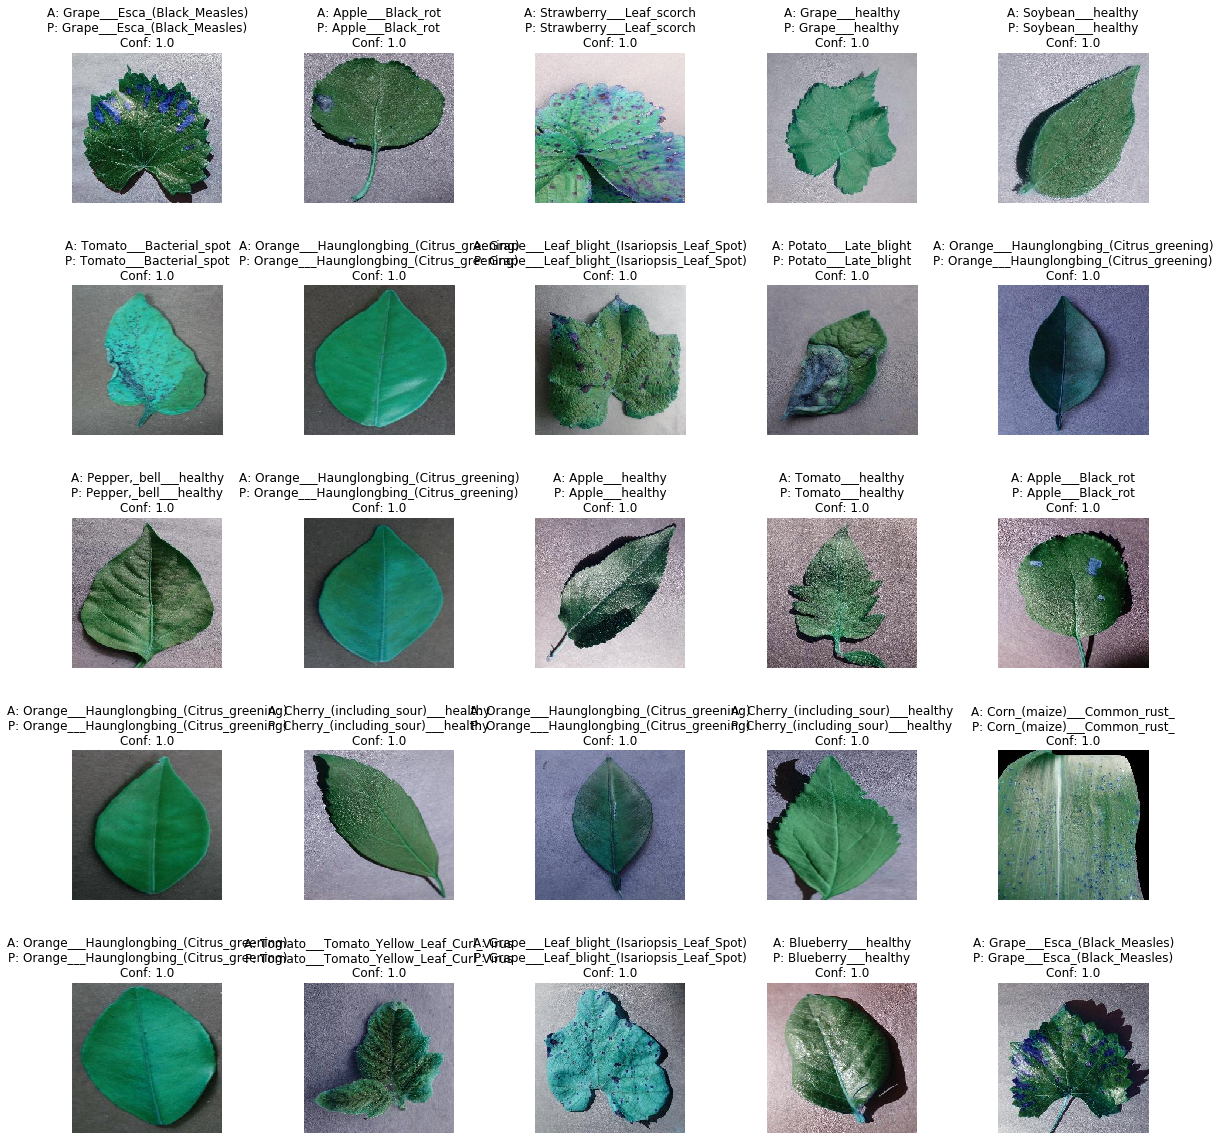

In [50]:
grid_width = 5
grid_height = 5
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(15, 15)

labels_ohe_names = pd.get_dummies(label_names, sparse=True)
labels_ohe = np.asarray(labels_ohe_names)
label_dict = dict(enumerate(labels_ohe_names.columns.values))

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        actual_label = label_names[(test_labels[img_idx])]
        prediction = test_predictions[img_idx]
        label_idx = np.argmax(prediction)
        predicted_label = label_names[label_idx]
        conf = round(prediction[label_idx], 2)
        ax[i][j].axis('off')
        ax[i][j].set_title('A: '+actual_label+'\nP: '+predicted_label + '\nConf: ' +str(conf))
        ax[i][j].imshow(cv2.imread('../../../../Datasets/PlantVillage-Dataset-master/raw/color_all_images/' + xyz[img_idx]))
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.55) 
f.savefig('post_process.png', bbox_inches='tight')

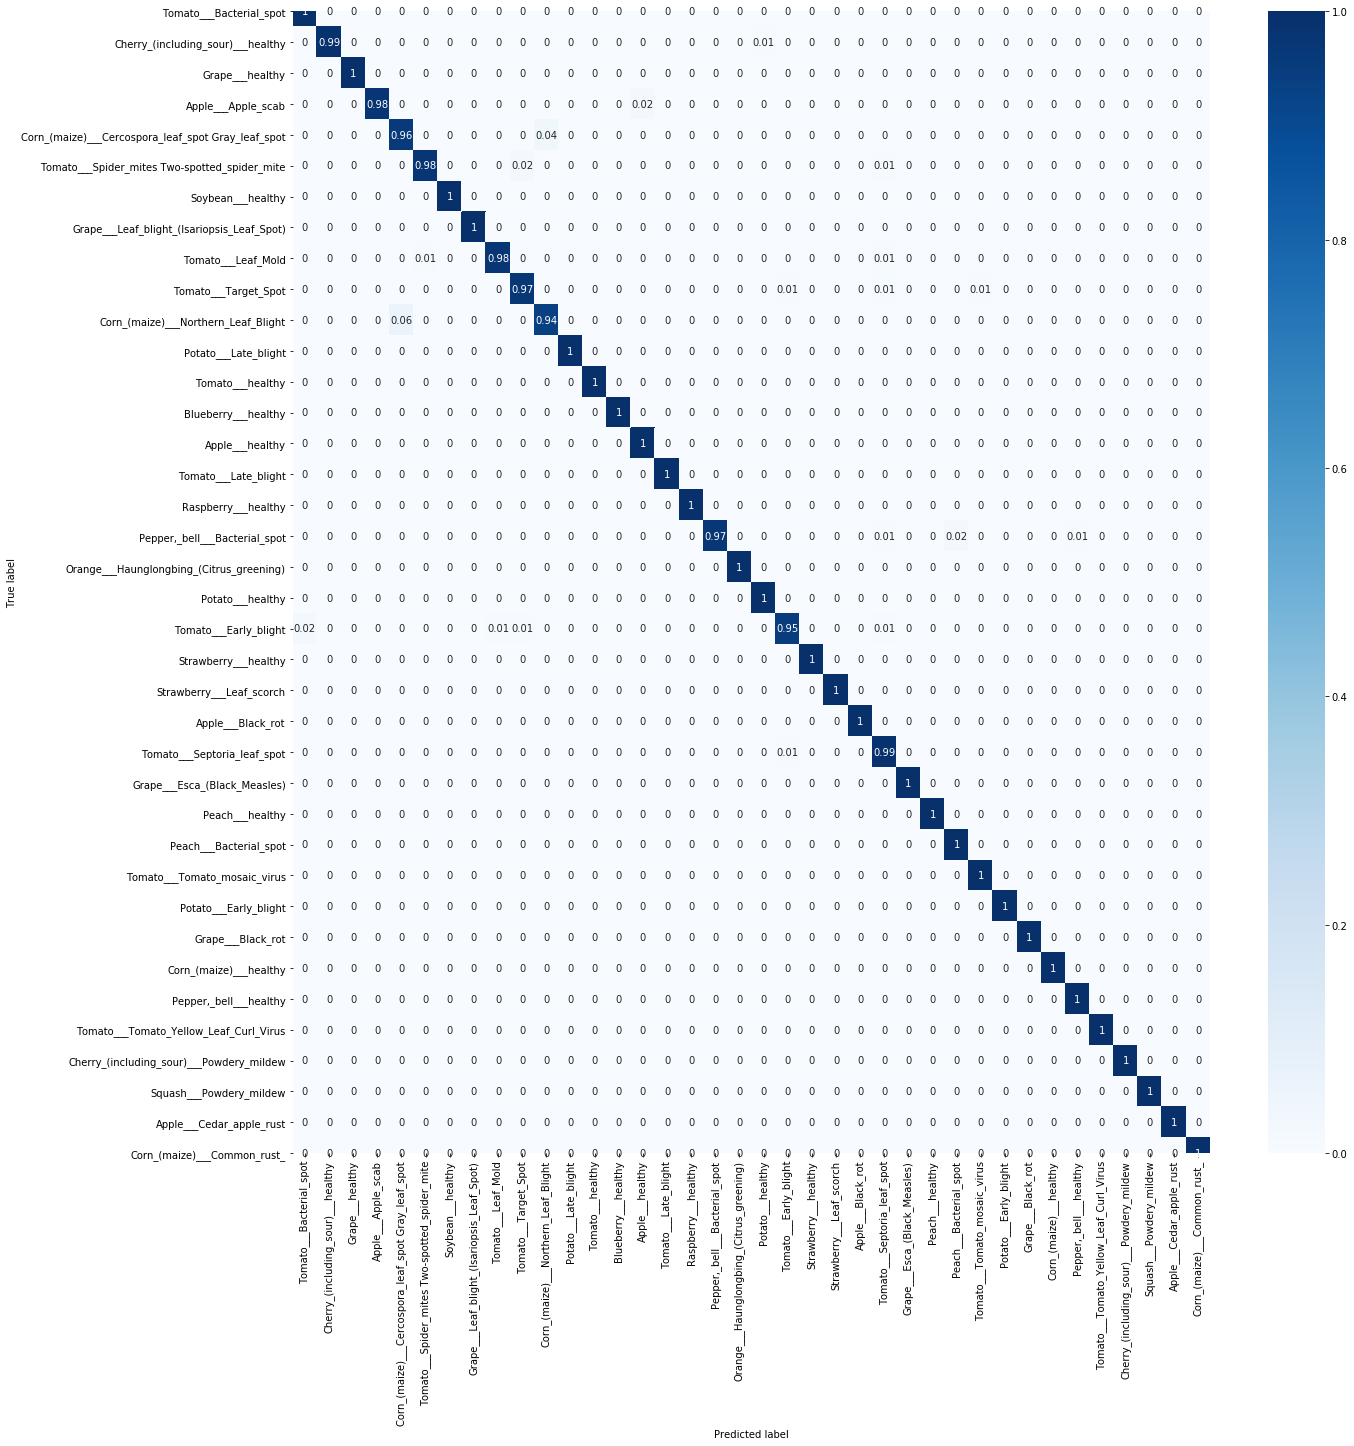

In [51]:
# Plotting Confusion Matrix
import seaborn as sns
con_mat = tensorflow.math.confusion_matrix(labels=test_labels, predictions=predictions).numpy()

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
 
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = label_names, 
                     columns = label_names)

figure = plt.figure(figsize=(20, 20))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
figure.savefig('confusion_matrix.png', bbox_inches='tight')

In [20]:
label_dict

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Blueberry___healthy',
 5: 'Cherry_(including_sour)___Powdery_mildew',
 6: 'Cherry_(including_sour)___healthy',
 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize)___Common_rust_',
 9: 'Corn_(maize)___Northern_Leaf_Blight',
 10: 'Corn_(maize)___healthy',
 11: 'Grape___Black_rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 14: 'Grape___healthy',
 15: 'Orange___Haunglongbing_(Citrus_greening)',
 16: 'Peach___Bacterial_spot',
 17: 'Peach___healthy',
 18: 'Pepper,_bell___Bacterial_spot',
 19: 'Pepper,_bell___healthy',
 20: 'Potato___Early_blight',
 21: 'Potato___Late_blight',
 22: 'Potato___healthy',
 23: 'Raspberry___healthy',
 24: 'Soybean___healthy',
 25: 'Squash___Powdery_mildew',
 26: 'Strawberry___Leaf_scorch',
 27: 'Strawberry___healthy',
 28: 'Tomato___Bacterial_spot',
 29: 'Tomato___Early_blight',
 30: '